```
  /$$$$$$  /$$   /$$ /$$$$$$$   /$$$$$$ 
 /$$__  $$| $$  | $$| $$__  $$ /$$__  $$
| $$  \__/| $$  | $$| $$  \ $$| $$  \ $$
|  $$$$$$ | $$  | $$| $$  | $$| $$  | $$
 \____  $$| $$  | $$| $$  | $$| $$  | $$
 /$$  \ $$| $$  | $$| $$  | $$| $$  | $$
|  $$$$$$/|  $$$$$$/| $$$$$$$/|  $$$$$$/
 \______/  \______/ |_______/  \______/ 


 @Author : Pierre Lague

 @Email : p.lague@sudogroup.fr

 @Date : 10/10/2024

```

This noteboook aims to demonstrate that it is possible to use Facebook Prophet in the objective of forecasting resource usage quantity on average per day.
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.


You will se throughout the notebook that Prophet comes in very handy and very promising in terms of forecasting and that is proposes a lot of tools to get more insight as well as state of the art methods to diagnose the model, explore it and understand it.

In [538]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [450]:
hash_data = pd.read_csv("./data/hash_df_vm.csv") #these are all the numerical datasets from the azure cloud bill
hex_data = pd.read_csv("./data/hex_df_vm.csv")
spacy_data = pd.read_csv("./data/spacy_df_vm.csv")
num_df = pd.read_csv("./data/num_df_vm.csv")


In [537]:
from sklearn.metrics import mutual_info_score

data = pd.concat([hex_data, hash_data, spacy_data, num_df], axis=1)

## Forecasting

In [536]:
data = data.reset_index(drop=True)

In [459]:
data['ds'] = pd.to_datetime(data['timestamp__Date'], unit='s')
df = data.set_index('ds')

# Group by resourceId and resample to daily frequency
df_daily = df.groupby('ResourceId').resample('D').agg({
    'Quantity': 'mean' 
})

df_daily = df_daily.reset_index()
df_daily = df_daily.rename(columns={'Quantity': 'y'})

              ds          y
0     2024-02-06  24.000000
1     2024-03-01   0.300006
2     2024-03-14   1.000000
3     2024-01-28   1.500000
4     2024-02-13   2.000000
...          ...        ...
11725 2024-03-26   0.900018
11726 2024-02-03  18.991677
11727 2024-01-15  18.000000
11728 2024-03-31  24.000000
11729 2024-02-16   0.983353

[11730 rows x 2 columns]


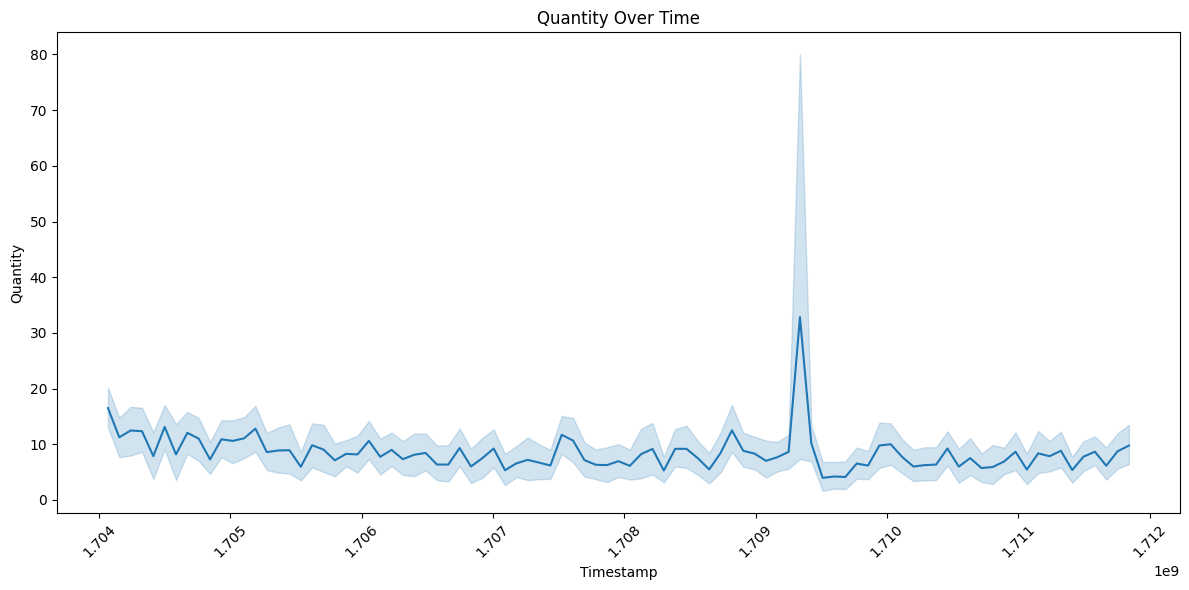

In [460]:
df_reset = data.reset_index()

df_reset = df_reset.sort_values('timestamp__Date')
# Create the plot
plt.figure(figsize=(12, 6))

# Use seaborn to create a line plot for each resourceId
sns.lineplot(data=df_reset, x='timestamp__Date', y='Quantity')

plt.title('Quantity Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Using Prophet

In [492]:
#prophet_df = df_reset[["ds", "Quantity"]]
#prophet_df = prophet_df.rename(columns={"Quantity":"y"})

prophet_df = df_daily[["ds", "y"]]

In [493]:
def aggregate_daily_quantity(df):
    # Convert the timestamp to datetime if it's not already
    df['ds'] = pd.to_datetime(df['ds'], unit='s')
    
    # Group by date and sum the quantity
    daily_df = df.groupby(df['ds'].dt.date)['y'].mean().reset_index()
    
    # Ensure the 'ds' column is in datetime format
    daily_df['ds'] = pd.to_datetime(daily_df['ds'])
    
    return daily_df

In [494]:
prophet_df = aggregate_daily_quantity(prophet_df)


C:\Users\Pierre LAGUE\AppData\Local\Temp\ipykernel_7068\644698952.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [495]:
prophet_df

,ds,y
0,2024-01-01,16.486422
1,2024-01-02,11.244593
2,2024-01-03,12.466002
3,2024-01-04,12.333199
4,2024-01-05,8.182296
...,...,...
86,2024-03-27,7.775660
87,2024-03-28,8.651871
88,2024-03-29,6.143437
89,2024-03-30,8.731032


In [496]:
from prophet import Prophet

In [527]:
m = Prophet(daily_seasonality=True, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1)
m.fit(prophet_df)

14:30:42 - cmdstanpy - INFO - Chain [1] start processing
14:30:43 - cmdstanpy - INFO - Chain [1] done processing


In [528]:
future = m.make_future_dataframe(periods=100)

,ds
186,2024-07-05
187,2024-07-06
188,2024-07-07
189,2024-07-08
190,2024-07-09


In [529]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
186,2024-07-05,2.073682,-1.852601,5.612523
187,2024-07-06,5.516017,1.797175,9.232979
188,2024-07-07,4.071622,0.178280,7.997365
189,2024-07-08,2.572381,-0.963706,6.293101
190,2024-07-09,1.884667,-1.880206,5.586334


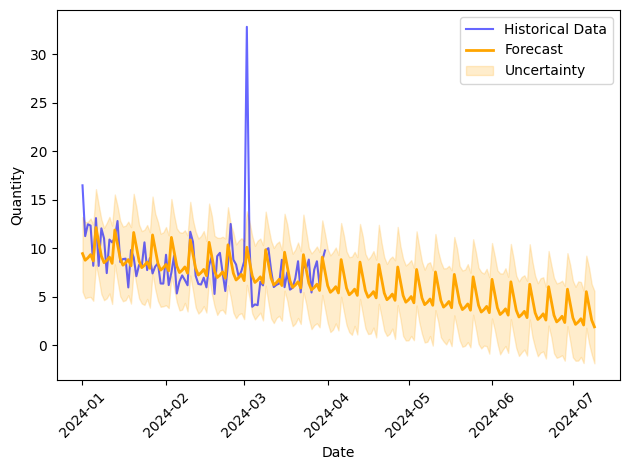

In [530]:
# Plot the historical data points
plt.plot(prophet_df['ds'], prophet_df['y'], color='blue', label='Historical Data', alpha=0.6)
plt.plot(forecast['ds'], forecast['yhat'], color='orange', label='Forecast', linewidth=2)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label="Uncertainty")

plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

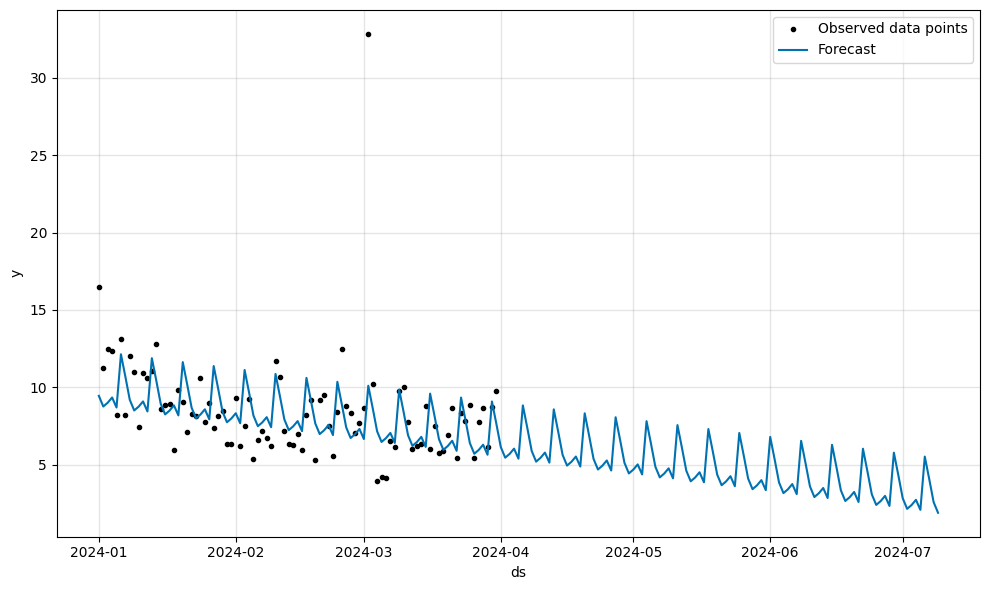

In [531]:
fig1 = m.plot(forecast, uncertainty=False, include_legend=True)

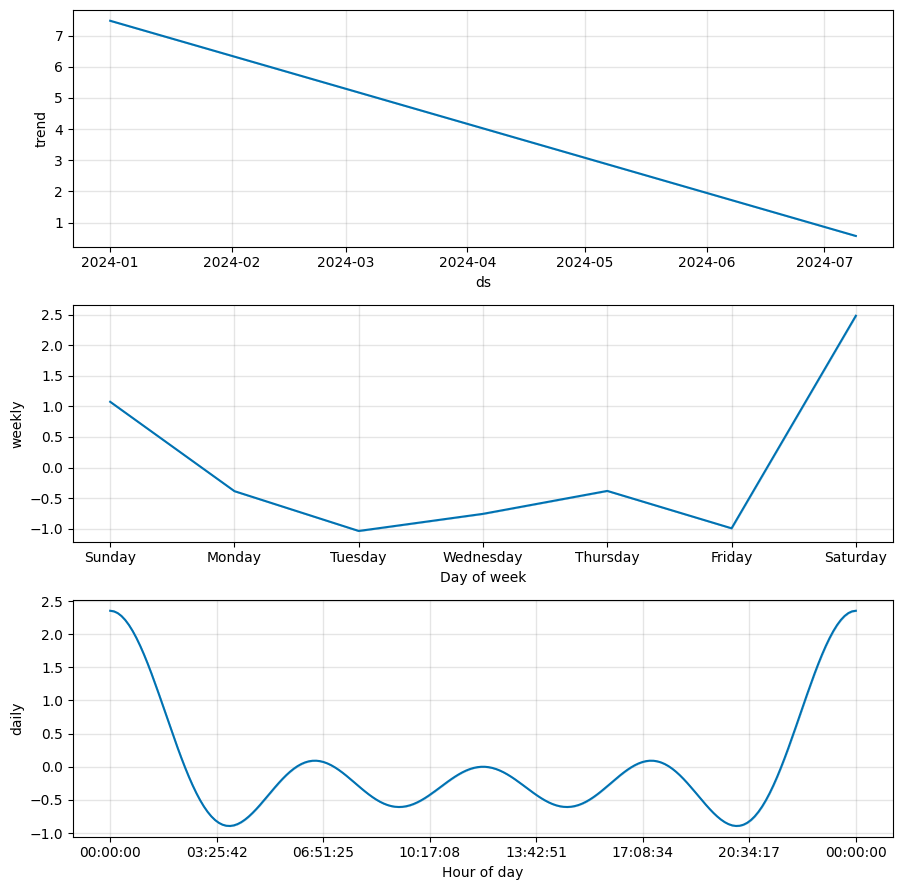

In [532]:
fig2 = m.plot_components(forecast)

In [533]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [436]:
plot_components_plotly(m, forecast)

# Diagnostics

In [521]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df_cv = cross_validation(m, horizon="10 days")
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/11 [00:00<?, ?it/s]14:25:40 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 1/11 [00:00<00:04,  2.40it/s]14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:00<00:04,  2.21it/s]14:25:41 - cmdstanpy - INFO - Chain [1] start processing
14:25:41 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 3/11 [00:01<00:03,  2.41it/s]14:25:42 - cmdstanpy - INFO - Chain [1] start processing
14:25:42 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:01<00:03,  2.23it/s]14:25:42 - cmdstanpy - INFO - Chain [1] start processing
14:25:42 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 5/11 [00:02<00:02,  2.15it/s]14:25:43 - cmdstanpy - INFO - Chain [1] start processing
14:25:43 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 6/11 [00:02<00:02,  1.94it/s]14:25:43

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,62.397119,7.899185,3.866853,0.251136,0.121472,0.322497,0.545455
1,2 days,1.816865,1.347911,1.121694,0.142884,0.164512,0.152656,1.000000
2,3 days,1.686435,1.298628,0.955914,0.156504,0.106453,0.145377,0.818182
3,4 days,3.458759,1.859774,1.668565,0.228474,0.190819,0.240501,0.909091
4,5 days,11.652877,3.413631,2.914328,0.365189,0.388874,0.384369,0.545455
5,6 days,65.299549,8.080814,4.000708,0.268005,0.179391,0.348297,0.636364
6,7 days,3.382280,1.839098,1.635477,0.206205,0.190513,0.229558,0.818182
7,8 days,3.291153,1.814153,1.450114,0.214739,0.261732,0.231135,0.818182
8,9 days,3.365408,1.834505,1.645493,0.219893,0.251752,0.242321,0.818182
9,10 days,14.323480,3.784637,3.243521,0.380811,0.370467,0.431020,0.454545


c:\Users\Pierre LAGUE\Documents\SUDO\.venv\Lib\site-packages\prophet\plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

c:\Users\Pierre LAGUE\Documents\SUDO\.venv\Lib\site-packages\prophet\plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



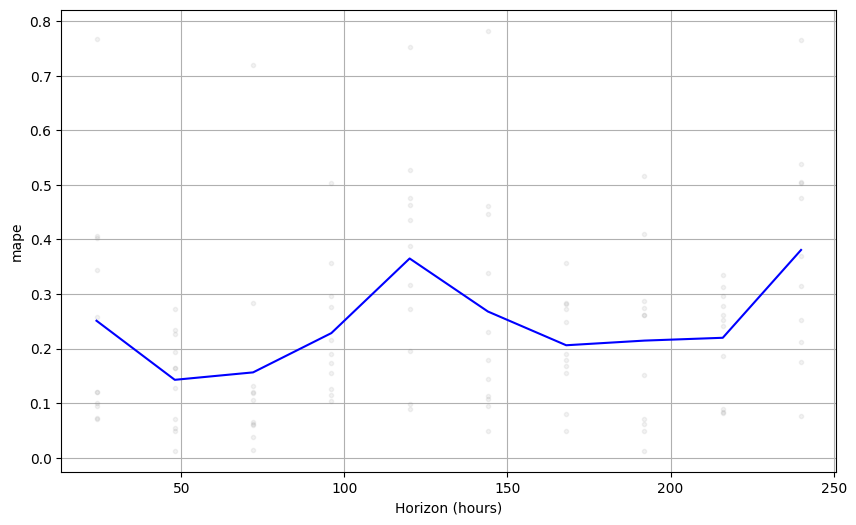

In [522]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [525]:
import itertools
import numpy as np
import pandas as pd
cutoffs = pd.to_datetime(['2024-01-14', '2024-02-14'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

14:28:45 - cmdstanpy - INFO - Chain [1] start processing
14:28:45 - cmdstanpy - INFO - Chain [1] done processing
14:28:50 - cmdstanpy - INFO - Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
14:28:55 - cmdstanpy - INFO - Chain [1] start processing
14:28:56 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:02 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:08 - cmdstanpy - INFO - Chain [1] start processing
14:29:09 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:14 - cmdstanpy - INFO - Chain [1] start processing
14:29:14 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01   4.728578
1                     0.001                     0.10   4.534876
2                     0.001                     1.00   4.767528
3                     0.001                    10.00   4.705789
4                     0.010                     0.01   4.702747
5                     0.010                     0.10   4.606136
6                     0.010                     1.00   4.628967
7                     0.010                    10.00   4.633717
8                     0.100                     0.01   4.639100
9                     0.100                     0.10   4.595682
10                    0.100                     1.00   4.616760
11                    0.100                    10.00   4.613817
12                    0.500                     0.01   8.447019
13                    0.500                     0.10  11.793815
14                    0.500             

In [526]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}
